# Classificação de Redes Sociais

Projeto da disciplina **SME0130 - Redes Complexas** administrada pelo Prof. Francisco Rodrigues

* Alexandre Eduardo de Souza Jesus - alexandre_souza@usp.br - 12559506

* Gustavo Silva de Oliveira - - 12567231

* Lucas Ivars Cadima Ciziks - luciziks@usp.br - 125599472

* Paloma Botto de Medeiros Serrão - palomabotto@usp.br - 12689641

---

In [1]:
# Importando Bibliotecas
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import math
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
import pandas as pd
from sklearn.impute import SimpleImputer

## 1. Introdução

## 2. Metodologia

A análise será realizada da seguinte forma:

* Selecionar algumas redes sociais para análise (http://konect.cc/categories/Social/);
* Para cada rede social, gerar cerca de 30 redes a partir dos modelos ER, BA, WS, etc, com o mesmo N e grau médio da rede real;
* Calcular medidas para cada rede, tais como distância, transitividade, etc;
* Projetar em 2D as redes e os modelos;
* Classificar a rede de acordo com os modelos (https://iopscience.iop.org/article/10.1088/1742-5468/2010/11/P11015/pdf).

## 3. Análise das Redes Sociais

### 3.1. Funções Úteis

In [31]:
# Função para calcular o momento do grau
def momment(grafo, m):
  M = 0
  n = len(grafo)

  for node in grafo.nodes():
    M += grafo.degree(node) ** m

  return M / n

In [32]:
# Função para calcular a distribuição de graus
def degree_distribution(grafo):
  degrees = list(dict(grafo.degree()).values())
  degrees_array = np.array(degrees)

  max = np.max(degrees_array)
  min = np.min(degrees_array)
  kvalues = np.arange(min, max + 1)
  Pk = np.zeros(max + 1)

  for k in degrees_array:
    Pk[k] += 1

  Pk /= sum(Pk)
  return kvalues, Pk

In [33]:
# Função para calcular Entropia de Shannon
def shannon_entropy(grafo):
  k, Pk = degree_distribution(grafo)
  H = 0
  for p in Pk:
    if(p > 0):
      H = H - p * math.log(p, 2)
  return H

In [34]:
# Função para calcular medidas da rede
def network_metrics(graph):
    avg_degree = momment(graph, 1)
    moment2 = momment(graph, 2)
    variance = moment2 - avg_degree**2
    avg_clustering = nx.average_clustering(graph)
    avg_shortest_path = nx.average_shortest_path_length(graph)
    assortativity = nx.degree_assortativity_coefficient(graph)
    transitivity = nx.transitivity(graph)
    entropy = shannon_entropy(graph)

    return  [avg_degree, moment2, variance, avg_clustering, avg_shortest_path, assortativity, transitivity, entropy]

In [35]:
# Função para gerar uma rede ER e coletar seu componente principal
def generate_ER(N, p):
    GER = nx.gnp_random_graph(N, p, seed=None, directed=False)
    Gcc = sorted(nx.connected_components(GER), key=len, reverse=True)
    GER = GER.subgraph(Gcc[0])

    GER = nx.convert_node_labels_to_integers(GER, first_label=0)

    return GER

# Função para gerar uma rede WS e coletar seu componente principal
def generate_WS(N, k, p):
    GWS = nx.watts_strogatz_graph(N, k, p, seed=None)
    Gcc = sorted(nx.connected_components(GWS), key=len, reverse=True)
    GWS = GWS.subgraph(Gcc[0])

    GWS = nx.convert_node_labels_to_integers(GWS, first_label=0)

    return GWS

# Função para gerar uma rede BA e coletar seu componente principal
def generate_BA(N, m):
    GBA = nx.barabasi_albert_graph(N, m)
    Gcc = sorted(nx.connected_components(GBA), key=len, reverse=True)
    GBA = GBA.subgraph(Gcc[0])

    GBA = nx.convert_node_labels_to_integers(GBA, first_label=0)

    return GBA

In [36]:
# Função para gerar o conjunto de treinamento para classificar a rede social
def generate_train_set(N, avg_degree, n_networks = 30):
    X_train = []
    y_train = []

    p = avg_degree / (N - 1)
    m = int(avg_degree/2)

    for i in range(n_networks):
        graph_ER = generate_ER(N, p)
        X_train.append(network_metrics(graph_ER))
        y_train.append(0.0)

        graph_WS = generate_WS(N, int(avg_degree), p)
        X_train.append(network_metrics(graph_WS))
        y_train.append(1.0)

        graph_BA = generate_BA(N, m)
        X_train.append(network_metrics(graph_BA))
        y_train.append(2.0)

    return np.array(X_train), np.array(y_train)

### 3.2. Petster Hamster Households

In [8]:
# Lendo rede social Petster http://konect.cc/networks/petster-hamster-household/
petster_graph = nx.read_edgelist("data/petster-hamster-household.txt", nodetype=int, data=(('weight',float),))
petster_graph = petster_graph.to_undirected()
petster_graph.remove_edges_from(nx.selfloop_edges(petster_graph))

# Selecionando maior componente
Gcc = sorted(nx.connected_components(petster_graph), key=len, reverse=True)
petster_graph = petster_graph.subgraph(Gcc[0])
petster_graph = nx.convert_node_labels_to_integers(petster_graph, first_label=0)

Number of nodes: 874
Number of edges: 4003


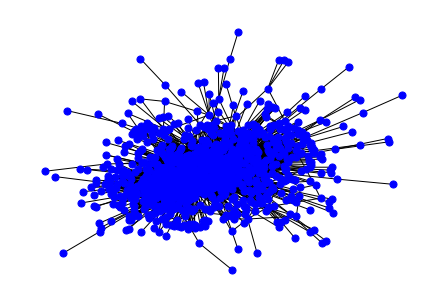

In [9]:
N = len(petster_graph)
M = petster_graph.number_of_edges()
print('Number of nodes:', N)
print('Number of edges:', M)

pos = nx.spring_layout(petster_graph)
nx.draw(petster_graph, pos, node_color="b", node_size=50, with_labels=False)

In [10]:
X_petster = np.array(network_metrics(petster_graph))
X_train, y_train = generate_train_set(N, X_petster[0])

In [11]:
# Ajustando a escala das variáveis com o StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

X_petster = X_petster.reshape(1, len(X_petster))
X_petster = scaler.transform(X_petster)
print('X_petster:', X_petster.shape)

X_petster: (1, 8)


In [12]:
# Aplicando Análise de Componentes Principais (PCA)
pca = PCA(n_components = 2)
X_r = pca.fit_transform(X_train)

# Compreendendo variância explicada
explained_variance = sum(pca.explained_variance_ratio_.tolist()[:2]) * 100
print(f"O PCA com 2 componentes principais explica {explained_variance:.4f}% da variância")

O PCA com 2 componentes principais explica 97.9087% da variância


In [13]:
X_r[y_train == 1.0, 0]

array([3.63400062, 3.09419152, 3.19030651, 2.91970498, 3.01559764,
       3.04041407, 3.20058185, 3.18340633, 3.65318261, 3.44519375,
       3.33834176, 3.56632616, 3.07338005, 3.28537092, 3.05818721,
       3.21022318, 3.5931878 , 2.94232966, 3.21207982, 3.165186  ,
       3.21548951, 3.28454342, 3.25489448, 3.38283934, 3.4537149 ,
       3.28661103, 3.37940722, 3.33041159, 3.1117007 , 3.30043072])

Text(0.5, 1.0, 'PCA Petster Network')

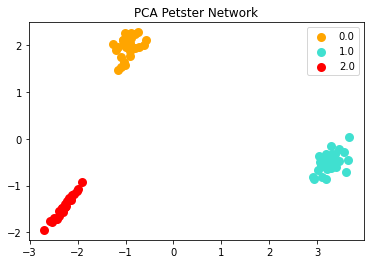

In [14]:
colors = ["orange", "turquoise", "red"]
lw = 3

for color, i in zip(colors, [0.0, 1.0, 2.0]):
    plt.scatter(
        X_r[y_train == i, 0], X_r[y_train == i, 1], color=color, lw=lw, label=i
    )
plt.legend(loc="best", shadow=False, scatterpoints=1)
plt.title("PCA Petster Network")

In [15]:
# Aplicando modelo KNN com 5 vizinhos
k = 5
model = KNeighborsClassifier(n_neighbors=k, metric='euclidean')
model.fit(X_r, y_train)

# faz a predição no conjunto de teste
X_petster = pca.transform(X_petster)
y_pred = model.predict(X_petster)
cl = ['ER','WS','BA']
print('Classe:', cl[int(y_pred)])

Classe: BA


/home/gustavo/miniconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


### 3.3. Facebook

In [16]:
# http://konect.cc/networks/ego-facebook/

facebook_graph = nx.read_edgelist("data/output.txt")
facebook_graph = facebook_graph.to_undirected()
facebook_graph.remove_edges_from(nx.selfloop_edges(facebook_graph))

# Selecionando maior componente
Gcc = sorted(nx.connected_components(facebook_graph), key=len, reverse=True)
facebook_graph = facebook_graph.subgraph(Gcc[0])
facebook_graph = nx.convert_node_labels_to_integers(facebook_graph, first_label=0)

Number of nodes: 2888
Number of edges: 2981


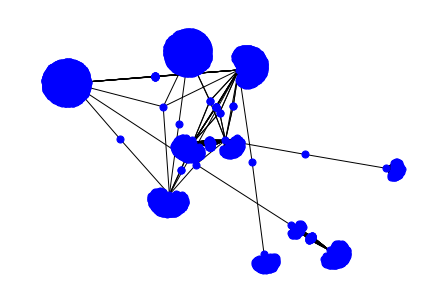

In [17]:
N = len(facebook_graph)
M = facebook_graph.number_of_edges()
print('Number of nodes:', N)
print('Number of edges:', M)

pos = nx.spring_layout(facebook_graph)
nx.draw(facebook_graph, pos, node_color="b", node_size=50, with_labels=False)

In [18]:
X_facebook = np.array(network_metrics(facebook_graph))
X_train, y_train = generate_train_set(N, X_facebook[0])

/home/gustavo/miniconda3/lib/python3.9/site-packages/networkx/algorithms/assortativity/correlation.py:298: RuntimeWarning: invalid value encountered in double_scalars
  return (xy * (M - ab)).sum() / np.sqrt(vara * varb)


In [19]:
# Ajustando a escala das variáveis com o StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

X_facebook = X_facebook.reshape(1, len(X_facebook))
X_facebook = scaler.transform(X_facebook)
print('X_facebook:', X_facebook.shape)

X_facebook: (1, 8)


In [20]:
# Tratando valores NaN
imp = SimpleImputer(strategy="mean")
X_train = imp.fit_transform(X_train)
X_train

array([[ 1.30792357e+00, -3.86666590e-01, -5.62073541e-01,
         1.14489272e+00, -6.90949689e-01, -2.55379027e-01,
         1.90453252e+00,  9.31638096e-01],
       [-7.03530920e-01, -9.55831607e-01, -8.05046902e-01,
        -4.33911088e-01,  1.60249650e+00,  1.31737407e+00,
        -5.25157737e-01, -1.38356544e+00],
       [-7.06751132e-01,  1.48858101e+00,  1.52312831e+00,
        -4.33911088e-01, -6.99162729e-01, -1.13752792e+00,
        -5.25157737e-01,  3.94971376e-01],
       [ 1.50486360e+00, -3.33015854e-01, -5.43397824e-01,
         5.72937043e-01, -6.92285931e-01, -8.65615794e-01,
         6.18743252e-01,  9.79310558e-01],
       [-7.03530920e-01, -9.55377951e-01, -8.04614899e-01,
        -4.33911088e-01,  1.77859135e+00,  1.30051271e+00,
        -5.25157737e-01, -1.35444896e+00],
       [-7.06751132e-01,  1.99554173e+00,  2.00589231e+00,
        -4.33911088e-01, -7.00018843e-01, -6.55199541e-01,
        -5.25157737e-01,  3.94586986e-01],
       [ 1.37458646e+00, -3.705637

In [21]:
# Aplicando Análise de Componentes Principais (PCA)
pca = PCA(n_components = 2)
X_r = pca.fit_transform(X_train)

# Compreendendo variância explicada
explained_variance = sum(pca.explained_variance_ratio_.tolist()[:2]) * 100
print(f"O PCA com 2 componentes principais explica {explained_variance:.4f}% da variância")

O PCA com 2 componentes principais explica 87.6581% da variância


In [22]:
X_r[y_train == 1.0, 0]

array([2.9381721 , 3.00396125, 2.3658241 , 2.3658241 , 2.3658241 ,
       2.79314402, 2.94064248, 2.72800474, 3.25114539, 2.82490061,
       2.69988729, 2.3658241 , 2.70651553, 2.73145122, 2.81792758,
       2.3658241 , 2.78699715, 2.81592431, 2.81536061, 3.13867154,
       2.80537565, 2.31305295, 2.86819987, 2.80676166, 2.87765694,
       2.79693631, 2.71654392, 2.90787423, 2.74197933, 2.60706042])

Text(0.5, 1.0, 'PCA Facebook Network')

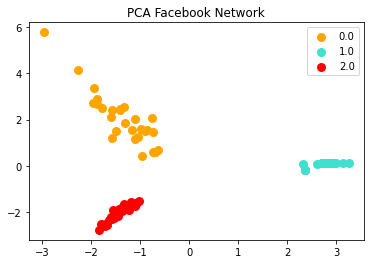

In [23]:
colors = ["orange", "turquoise", "red"]
lw = 3

for color, i in zip(colors, [0.0, 1.0, 2.0]):
    plt.scatter(
        X_r[y_train == i, 0], X_r[y_train == i, 1], color=color, lw=lw, label=i
    )
plt.legend(loc="best", shadow=False, scatterpoints=1)
plt.title("PCA Facebook Network")

In [24]:
# Aplicando modelo KNN com 5 vizinhos
k = 5
model = KNeighborsClassifier(n_neighbors=k, metric='euclidean')
model.fit(X_r, y_train)

# faz a predição no conjunto de teste
X_facebook = pca.transform(X_facebook)
y_pred = model.predict(X_facebook)
cl = ['ER','WS','BA']
print('Classe:', cl[int(y_pred)])

Classe: BA


/home/gustavo/miniconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


### 3.4. FilmTrust Trust

http://konect.cc/networks/librec-filmtrust-trust/

In [37]:
# Lendo rede social Twitter Lists
filmtrust_graph = nx.read_edgelist("data/filmtrust.txt", nodetype=int)
filmtrust_graph = filmtrust_graph.to_undirected()
filmtrust_graph.remove_edges_from(nx.selfloop_edges(filmtrust_graph))

# Selecionando maior componente
Gcc = sorted(nx.connected_components(filmtrust_graph), key=len, reverse=True)
filmtrust_graph = filmtrust_graph.subgraph(Gcc[0])
filmtrust_graph = nx.convert_node_labels_to_integers(filmtrust_graph, first_label=0)

Number of nodes: 610
Number of edges: 1119


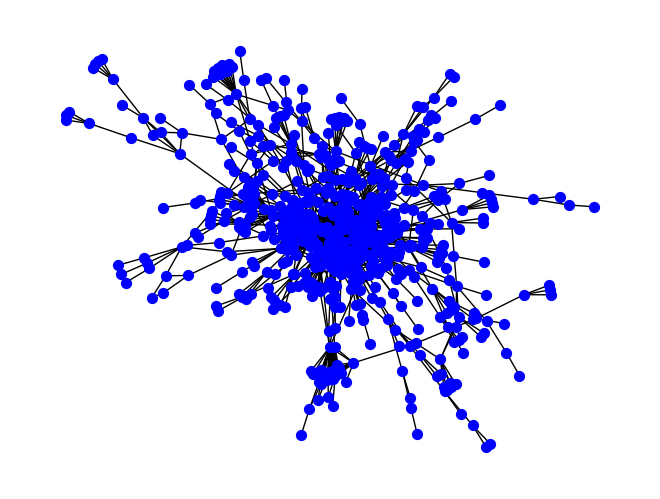

In [38]:
N = len(filmtrust_graph)
M = filmtrust_graph.number_of_edges()
print('Number of nodes:', N)
print('Number of edges:', M)

pos = nx.spring_layout(filmtrust_graph)
nx.draw(filmtrust_graph, pos, node_color="b", node_size=50, with_labels=False)

In [39]:
X_filmtrust = np.array(network_metrics(filmtrust_graph))
X_train, y_train = generate_train_set(N, X_filmtrust[0])

In [40]:
# Ajustando a escala das variáveis com o StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

X_filmtrust = X_filmtrust.reshape(1, len(X_filmtrust))
X_filmtrust = scaler.transform(X_filmtrust)
print('X_filmtrust:', X_filmtrust.shape)

X_filmtrust: (1, 8)


In [41]:
# Tratando os valores NaN
imp = SimpleImputer(strategy="mean")
X_train = imp.fit_transform(X_train)

In [42]:
# Aplicando Análise de Componentes Principais (PCA)
pca = PCA(n_components = 2)
X_r = pca.fit_transform(X_train)

# Compreendendo variância explicada
explained_variance = sum(pca.explained_variance_ratio_.tolist()[:2]) * 100
print(f"O PCA com 2 componentes principais explica {explained_variance:.4f}% da variância")

O PCA com 2 componentes principais explica 94.0109% da variância


In [43]:
X_r[y_train == 1.0, 0]

array([-2.50769856, -2.50778977, -2.64395509, -2.58773996, -2.12734606,
       -2.40719602, -2.56296537, -2.3088625 , -2.58388888, -2.69522113,
       -2.34272996, -2.70189087, -2.20370861, -2.55656416, -2.48564592,
       -2.3837539 , -2.32639346, -2.7657891 , -2.52600519, -2.77681311,
       -2.41979942, -2.53829429, -2.6027798 , -2.60312405, -2.1672827 ,
       -2.86300832, -2.9320649 , -2.61105769, -2.52245832, -2.48919092])

Text(0.5, 1.0, 'PCA FilmTrust Trust Network')

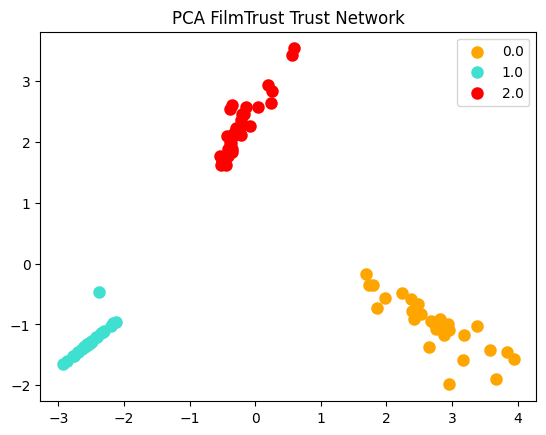

In [44]:
lw = 3

for color, i in zip(colors, [0.0, 1.0, 2.0]):
    plt.scatter(
        X_r[y_train == i, 0], X_r[y_train == i, 1], color=color, lw=lw, label=i
    )
plt.legend(loc="best", shadow=False, scatterpoints=1)
plt.title("PCA FilmTrust Trust Network")

In [45]:
# Aplicando modelo KNN com 5 vizinhos
k = 5
model = KNeighborsClassifier(n_neighbors=k, metric='euclidean')
model.fit(X_r, y_train)

# faz a predição no conjunto de teste
X_filmtrust = pca.transform(X_filmtrust)
y_pred = model.predict(X_filmtrust)
cl = ['ER','WS','BA']
print('Classe:', cl[int(y_pred)])

Classe: ER


### 3.5. Google+

In [25]:
http://konect.cc/networks/ego-gplus/

SyntaxError: invalid syntax (1744214640.py, line 1)

### 4. Conclusão

### 5. Referências Bibliográficas

* http://konect.cc/

* https://iopscience.iop.org/article/10.1088/1742-5468/2010/11/P11015/pdf